In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_163.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_330.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_498.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_167.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_76.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_439.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_226.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_168.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_96.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_64.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_373.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_115.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_20.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/Closed/_559.jpg
/kaggle/input/yawn-eye-dataset-new/dataset_new/test/

# Import các thư viện

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

### 1. Tiền xử lý dữ liệu
Dataset được tổ chức thành 4 lớp: `Closed`, `Open`, `no_yawn`, `yawn`. Để huấn luyện mô hình:
- Áp dụng các biến đổi (transforms) như thay đổi kích thước ảnh về 224x224 (phù hợp với VGG16), chuẩn hóa giá trị pixel.
- Chia dữ liệu thành tập train và test bằng cách sử dụng cấu trúc thư mục có sẵn.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/yawn-eye-dataset-new/dataset_new'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

# Tính trọng số lớp (tăng trọng số cho lớp yawn)
targets = np.array(image_datasets['train'].targets)
class_counts = [sum(targets == i) for i in range(len(class_names))]
print(f"Class counts: {class_counts}")

Classes: ['Closed', 'Open', 'no_yawn', 'yawn']
Dataset sizes: {'train': 2467, 'test': 433}
Class counts: [617, 617, 616, 617]


In [5]:
class_weights = torch.FloatTensor([1.0, 1.0, 1.0, 1.5]).to(device)  # Tăng trọng số lớp yawn

### 2. Xây dựng mô hình chung cho backbone
- Sử dụng các backbone pre-trained từ `torchvision`.
- Thay đổi lớp fully connected cuối cùng để phù hợp với 4 lớp đầu ra: `Closed`, `Open`, `no_yawn`, `yawn`.
- Đóng băng các tầng convolution để giữ lại đặc trưng đã học, chỉ huấn luyện tầng fully connected.

In [6]:
def get_model(backbone_name, num_classes, class_weights):
    if backbone_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    elif backbone_name == 'mobilenet_v3_small':
        model = models.mobilenet_v3_small(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    elif backbone_name == 'efficientnet_b0':
        model = models.efficientnet_b0(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)
        )
    else:
        raise ValueError('Unsupported backbone!')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    return model, criterion, optimizer, scheduler


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_acc = 0.0
    best_model_path = f'/kaggle/working/{backbone}_model.pth'
    trigger_times = 0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                test_losses.append(epoch_loss)
                test_accs.append(epoch_acc.item())
                scheduler.step()
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_path)
                    print(f'Saved best model with Test Acc: {best_acc:.4f}')
                    trigger_times = 0
                else:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print(f'Early stopping triggered after {epoch+1} epochs!')
                        return model, train_losses, test_losses, train_accs, test_accs
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return model, train_losses, test_losses, train_accs, test_accs


### 3. Huấn luyện mô hình
- Huấn luyện trên tập train với 25 epochs (có thể điều chỉnh).
- Sử dụng Adam optimizer với learning rate = 0.001.
- Lưu lại loss và accuracy cho từng epoch để trực quan hóa.

In [8]:
backbone_list = ['mobilenet_v2', 'mobilenet_v3_small', 'efficientnet_b0']
all_results = {}

for backbone in backbone_list:
    print(f"\n====== Training {backbone} ======")
    model, criterion, optimizer, scheduler = get_model(backbone, num_classes=4, class_weights=class_weights)
    model, train_losses, test_losses, train_accs, test_accs = train_model(
        model, criterion, optimizer, scheduler, num_epochs=25
    )
    # Lưu lại kết quả từng model
    all_results[backbone] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
    }



====== Training mobilenet_v2 ======


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 95.0MB/s]


Epoch 1/25
----------
train Loss: 0.8571 Acc: 0.6376
Saved best model with Test Acc: 0.7436
test Loss: 0.5549 Acc: 0.7436
Epoch 2/25
----------
train Loss: 0.5019 Acc: 0.7783
Saved best model with Test Acc: 0.7621
test Loss: 0.4262 Acc: 0.7621
Epoch 3/25
----------
train Loss: 0.4477 Acc: 0.7933
Saved best model with Test Acc: 0.7714
test Loss: 0.3881 Acc: 0.7714
Epoch 4/25
----------
train Loss: 0.4089 Acc: 0.8152
Saved best model with Test Acc: 0.8476
test Loss: 0.3425 Acc: 0.8476
Epoch 5/25
----------
train Loss: 0.3826 Acc: 0.8306
test Loss: 0.3240 Acc: 0.8453
Epoch 6/25
----------
train Loss: 0.3510 Acc: 0.8350
test Loss: 0.3324 Acc: 0.8176
Epoch 7/25
----------
train Loss: 0.3422 Acc: 0.8427
Saved best model with Test Acc: 0.8845
test Loss: 0.3067 Acc: 0.8845
Epoch 8/25
----------
train Loss: 0.3412 Acc: 0.8472
test Loss: 0.2921 Acc: 0.8707
Epoch 9/25
----------
train Loss: 0.3315 Acc: 0.8492
test Loss: 0.3077 Acc: 0.8268
Epoch 10/25
----------
train Loss: 0.3256 Acc: 0.8593
test

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


Early stopping triggered after 12 epochs!

====== Training mobilenet_v3_small ======


100%|██████████| 9.83M/9.83M [00:00<00:00, 92.2MB/s]

Epoch 1/25
----------


train Loss: 0.7333 Acc: 0.7195
Saved best model with Test Acc: 0.8014
test Loss: 0.4448 Acc: 0.8014
Epoch 2/25
----------
train Loss: 0.3964 Acc: 0.8103
Saved best model with Test Acc: 0.8545
test Loss: 0.3431 Acc: 0.8545
Epoch 3/25
----------
train Loss: 0.3508 Acc: 0.8338
Saved best model with Test Acc: 0.9007
test Loss: 0.2819 Acc: 0.9007
Epoch 4/25
----------
train Loss: 0.3203 Acc: 0.8589
Saved best model with Test Acc: 0.9030
test Loss: 0.2659 Acc: 0.9030
Epoch 5/25
----------
train Loss: 0.3022 Acc: 0.8662
test Loss: 0.2499 Acc: 0.8776
Epoch 6/25
----------
train Loss: 0.2953 Acc: 0.8658
Saved best model with Test Acc: 0.9215
test Loss: 0.2203 Acc: 0.9215
Epoch 7/25
----------
train Loss: 0.2675 Acc: 0.8816
test Loss: 0.2086 Acc: 0.9169
Epoch 8/25
----------
train Loss: 0.2711 Acc: 0.8873
Saved best model with Test Acc: 0.9307
test Loss: 0.2090 Acc: 0.9307
Epoch 9/25
----------
train Loss: 0.2502 Acc: 0.8906
test Loss: 0.2201 Acc: 0.8961
Epoch 10/25
----------
train Loss: 0.2531

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 115MB/s] 


Epoch 1/25
----------
train Loss: 0.9529 Acc: 0.5926
Saved best model with Test Acc: 0.7159
test Loss: 0.6820 Acc: 0.7159
Epoch 2/25
----------
train Loss: 0.5362 Acc: 0.7896
Saved best model with Test Acc: 0.8337
test Loss: 0.4694 Acc: 0.8337
Epoch 3/25
----------
train Loss: 0.4211 Acc: 0.8253
Saved best model with Test Acc: 0.8753
test Loss: 0.3786 Acc: 0.8753
Epoch 4/25
----------
train Loss: 0.3694 Acc: 0.8484
Saved best model with Test Acc: 0.8938
test Loss: 0.3344 Acc: 0.8938
Epoch 5/25
----------
train Loss: 0.3280 Acc: 0.8707
test Loss: 0.3141 Acc: 0.8637
Epoch 6/25
----------
train Loss: 0.3155 Acc: 0.8776
test Loss: 0.2968 Acc: 0.8891
Epoch 7/25
----------
train Loss: 0.2882 Acc: 0.8808
Saved best model with Test Acc: 0.8961
test Loss: 0.2653 Acc: 0.8961
Epoch 8/25
----------
train Loss: 0.2786 Acc: 0.8926
test Loss: 0.2752 Acc: 0.8776
Epoch 9/25
----------
train Loss: 0.2746 Acc: 0.8930
Saved best model with Test Acc: 0.9215
test Loss: 0.2375 Acc: 0.9215
Epoch 10/25
-------

### 4. Đánh giá mô hình
- Vẽ biểu đồ loss và accuracy cho tập train/test.
- Tính toán và hiển thị ma trận nhầm lẫn trên tập test để đánh giá hiệu suất từng lớp.

In [9]:
def evaluate_and_plot(model, dataloader, class_names, backbone_name):
    # Lấy loss và acc đã lưu từ all_results nếu có
    train_losses = all_results[backbone_name]['train_losses']
    test_losses = all_results[backbone_name]['test_losses']
    train_accs = all_results[backbone_name]['train_accs']
    test_accs = all_results[backbone_name]['test_accs']

    # Vẽ biểu đồ loss & accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Loss over Epochs ({backbone_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title(f'Accuracy over Epochs ({backbone_name})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Dự đoán và gom nhãn
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Ma trận nhầm lẫn
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'Confusion Matrix ({backbone_name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Precision, Recall, F1-score
    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
    overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

    print(f"=== Đánh giá hiệu suất phân loại: {backbone_name} ===")
    print(f"Overall Accuracy: {overall_accuracy:.4f}\n")
    print("Chi tiết từng lớp:")
    for i, class_name in enumerate(class_names):
        print(f"Lớp {class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
        print(f"  Support: {support[i]} (số mẫu)\n")
    print("Trung bình (Macro Average):")
    print(f"  Precision: {precision_macro:.4f}")
    print(f"  Recall: {recall_macro:.4f}")
    print(f"  F1-Score: {f1_macro:.4f}")

    # Có thể trả về các chỉ số nếu muốn lưu lại
    return overall_accuracy, precision, recall, f1, cm


### 5. Kết luận
- Mô hình Backbone đã được huấn luyện thành công trên dataset Yawn Eye.
- Các biểu đồ loss/accuracy và ma trận nhầm lẫn cho thấy hiệu suất của mô hình.
- Có thể cải thiện thêm bằng cách: tăng số epoch, điều chỉnh learning rate, hoặc sử dụng kỹ thuật data augmentation mạnh hơn.

### 6. Kiểm tra mô hình
- Tải lại mô hình tốt nhất đã lưu.
- Dự đoán trên tập test và hiển thị một số ví dụ kết quả (ảnh + nhãn thực tế + nhãn dự đoán).

Testing the best model on test data:


<ipython-input-10-11a4a74e2986>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/kaggle/working/{backbone}_model.pth'))


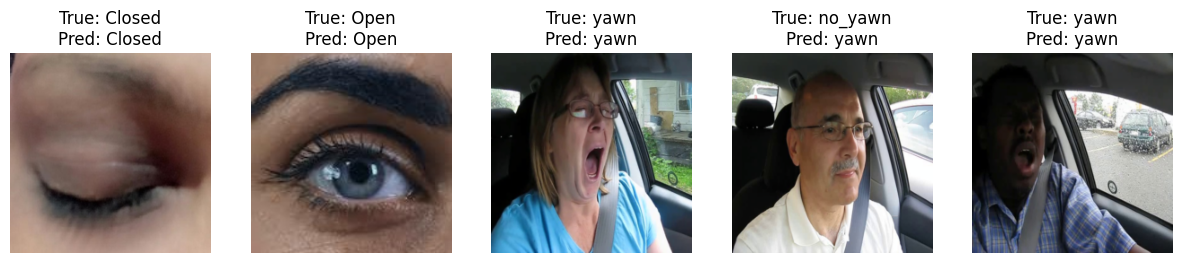

In [10]:
# Hàm kiểm tra mô hình
def test_model(model, dataloader, num_images=5):
    model.eval()
    images_shown = 0
    
    # Tải mô hình tốt nhất
    model.load_state_dict(torch.load(f'/kaggle/working/{backbone}_model.pth'))
    model.to(device)
    
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Hiển thị một số ảnh cùng với nhãn
            for j in range(inputs.size()[0]):
                if images_shown >= num_images:
                    break
                images_shown += 1
                
                ax = plt.subplot(1, num_images, images_shown)
                ax.axis('off')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
            
            if images_shown >= num_images:
                break
    
    plt.show()

# Kiểm tra mô hình
print("Testing the best model on test data:")
test_model(model, dataloaders, num_images=5)


--- Đánh giá mô hình: mobilenet_v2 ---


<ipython-input-11-25f3641f6841>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/kaggle/working/{backbone}_model.pth"))


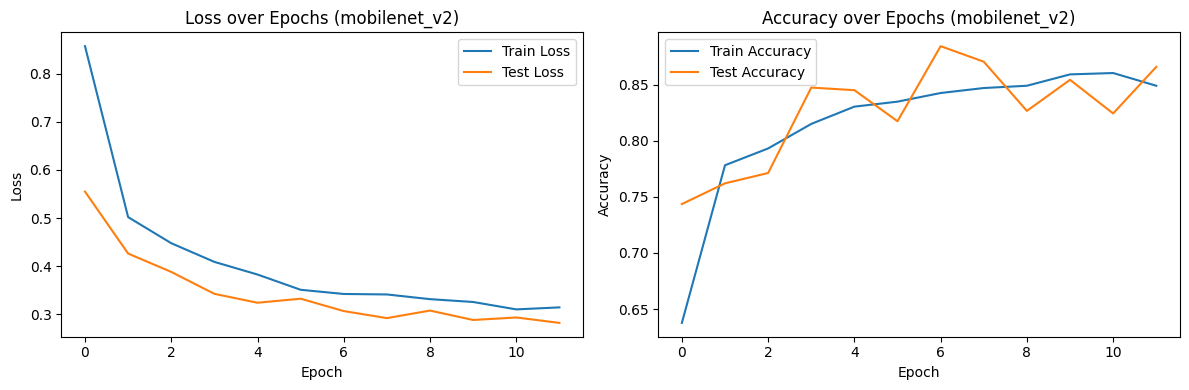

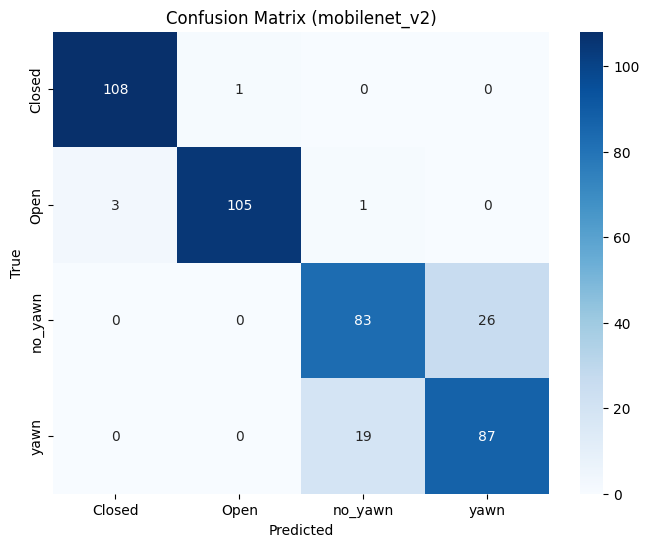

=== Đánh giá hiệu suất phân loại: mobilenet_v2 ===
Overall Accuracy: 0.8845

Chi tiết từng lớp:
Lớp Closed:
  Precision: 0.9730
  Recall: 0.9908
  F1-Score: 0.9818
  Support: 109 (số mẫu)

Lớp Open:
  Precision: 0.9906
  Recall: 0.9633
  F1-Score: 0.9767
  Support: 109 (số mẫu)

Lớp no_yawn:
  Precision: 0.8058
  Recall: 0.7615
  F1-Score: 0.7830
  Support: 109 (số mẫu)

Lớp yawn:
  Precision: 0.7699
  Recall: 0.8208
  F1-Score: 0.7945
  Support: 106 (số mẫu)

Trung bình (Macro Average):
  Precision: 0.8848
  Recall: 0.8841
  F1-Score: 0.8840

--- Đánh giá mô hình: mobilenet_v3_small ---


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-11-25f3641f6841>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mo

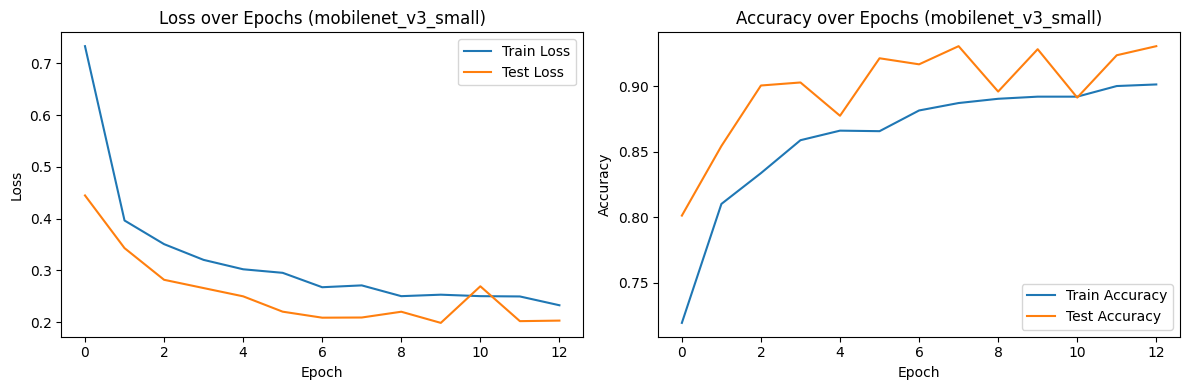

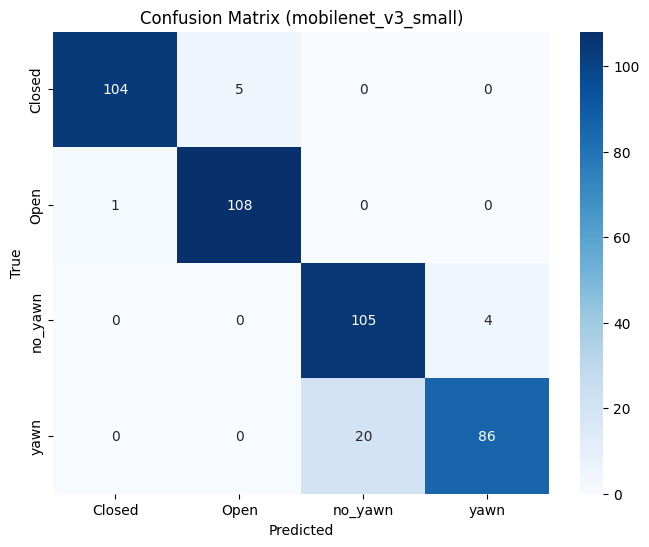

=== Đánh giá hiệu suất phân loại: mobilenet_v3_small ===
Overall Accuracy: 0.9307

Chi tiết từng lớp:
Lớp Closed:
  Precision: 0.9905
  Recall: 0.9541
  F1-Score: 0.9720
  Support: 109 (số mẫu)

Lớp Open:
  Precision: 0.9558
  Recall: 0.9908
  F1-Score: 0.9730
  Support: 109 (số mẫu)

Lớp no_yawn:
  Precision: 0.8400
  Recall: 0.9633
  F1-Score: 0.8974
  Support: 109 (số mẫu)

Lớp yawn:
  Precision: 0.9556
  Recall: 0.8113
  F1-Score: 0.8776
  Support: 106 (số mẫu)

Trung bình (Macro Average):
  Precision: 0.9354
  Recall: 0.9299
  F1-Score: 0.9300

--- Đánh giá mô hình: efficientnet_b0 ---


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-11-25f3641f6841>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

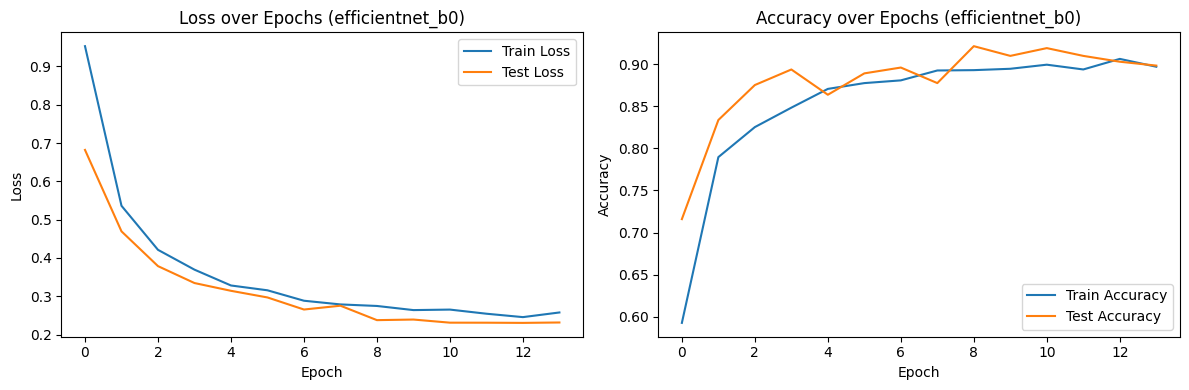

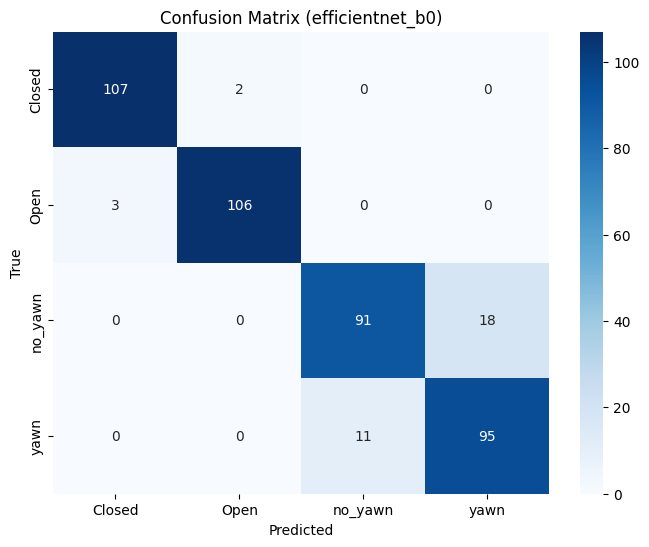

=== Đánh giá hiệu suất phân loại: efficientnet_b0 ===
Overall Accuracy: 0.9215

Chi tiết từng lớp:
Lớp Closed:
  Precision: 0.9727
  Recall: 0.9817
  F1-Score: 0.9772
  Support: 109 (số mẫu)

Lớp Open:
  Precision: 0.9815
  Recall: 0.9725
  F1-Score: 0.9770
  Support: 109 (số mẫu)

Lớp no_yawn:
  Precision: 0.8922
  Recall: 0.8349
  F1-Score: 0.8626
  Support: 109 (số mẫu)

Lớp yawn:
  Precision: 0.8407
  Recall: 0.8962
  F1-Score: 0.8676
  Support: 106 (số mẫu)

Trung bình (Macro Average):
  Precision: 0.9218
  Recall: 0.9213
  F1-Score: 0.9211


In [11]:
from collections import defaultdict
metrics_dict = defaultdict(dict)

for backbone in backbone_list:
    print(f"\n--- Đánh giá mô hình: {backbone} ---")
    # Load best model nếu cần
    model, _, _, _ = get_model(backbone, num_classes=4, class_weights=class_weights)
    model.load_state_dict(torch.load(f"/kaggle/working/{backbone}_model.pth"))
    model = model.to(device)
    # Đánh giá
    overall_acc, prec, rec, f1, cm = evaluate_and_plot(model, dataloaders['test'], class_names, backbone)
    metrics_dict[backbone]['overall_acc'] = overall_acc
    metrics_dict[backbone]['precision'] = prec
    metrics_dict[backbone]['recall'] = rec
    metrics_dict[backbone]['f1'] = f1
    metrics_dict[backbone]['confusion_matrix'] = cm
